# Librerias

In [1]:
!nvidia-smi

Mon Apr 12 08:33:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   32C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |                    0 |
| N/A   

In [2]:
!pip show transformers

Name: transformers
Version: 4.5.0
Summary: State-of-the-art Natural Language Processing for TensorFlow 2.0 and PyTorch
Home-page: https://github.com/huggingface/transformers
Author: Thomas Wolf, Lysandre Debut, Victor Sanh, Julien Chaumond, Sam Shleifer, Patrick von Platen, Sylvain Gugger, Google AI Language Team Authors, Open AI team Authors, Facebook AI Authors, Carnegie Mellon University Authors
Author-email: thomas@huggingface.co
License: Apache
Location: /anaconda/envs/py37_pytorch/lib/python3.7/site-packages
Requires: filelock, tokenizers, packaging, tqdm, numpy, sacremoses, importlib-metadata, requests, regex
Required-by: bertviz


In [3]:
from sklearn.model_selection import train_test_split
import torch

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%%capture
!pip install wandb
import wandb
wandb.login()

In [6]:
wandb.login()

True

# Carga de datos
- incluidas nuevas columnas con concatenacion de review_body y categoria, review_body y titulo
- nuevos indices para star rating, de 0-4 en vez de 1-5
- numericalizar las categorias de los productos, 31 en total


In [7]:
#from google.colab import drive
#drive.mount('/content/drive')

In [38]:
# Load data
import pandas as pd

## Para TRAIN, en [ español ] y [ español + 10 ej en inglés ] 

path1 = "chatbot_trainES.csv"
#path1 = "chatbot_train_fewshotEN"

## Para VALID, en español
path2 = "chatbot_validES.csv"


## Para TEST, en ingles

#path3 = "chatbot_testES.csv"
#path3 = "chatbot_test_fewshotEN"

# Dato test comparación few shots
path3 = 'test_muse_EN'
test_data = pd.read_csv(path3)
test_data = test_data.rename(columns = {'query_test': 'Query', 'kb_label_test': 'kb_label','category_cod_test':'category_cod'})
test_data

####### CONVERTIMOS A DATAFRAMES #########

df_train = pd.read_csv(path1)
df_train = df_train

df_valid = pd.read_csv(path2)
df_valid = df_valid

df_test = pd.read_csv(path3)
df_test = test_data

In [39]:
df_test.head()

,Query,kb_label,category_cod
0,how to change password using repsol mobile app,Correo Electrónico | Email,5
1,i want to add members to a distributi...,Correo Electrónico | Email,5
2,ok assigning roles in sap systems erp,SAP,18
3,se solicita asignar en sap al usuario chia...,SAP,18
4,i am trying to create an incident in unity but...,UNITY,25


# Carga modelo mBERT
- incluye tokenizer

In [9]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
from transformers import BertModel, BertConfig, BertTokenizer
from transformers import BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# mBertForSequenceClassification - Category
- Clasificación Category a partir de Query

In [10]:
%env WANDB_PROJECT = RATING CLASSIFICATION mBERT -CHATBOT

env: WANDB_PROJECT=RATING CLASSIFICATION mBERT -CHATBOT


In [41]:
RANDOM_SEED=8
MAX_LENGTH=200


## CLASES DEL CLASIFICADOR 

class_names = df_train.kb_label.unique()

In [42]:
#TOKENIZAMOS LOS DATAFRAMES

train_encodings = tokenizer(df_train.Query.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

val_encodings = tokenizer(df_valid.Query.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_encodings = tokenizer(df_test.Query.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

In [43]:
class GPReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [44]:
train_labels = df_train.category_cod.values
val_labels = df_valid.category_cod.values
test_labels = df_test.category_cod.values

In [45]:
train_data = GPReviewDataset(train_encodings, torch.from_numpy(train_labels))
val_data = GPReviewDataset(val_encodings, torch.from_numpy(val_labels))
test_data = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

In [16]:
from transformers import BertForSequenceClassification

## DEFINIMOS EL MODELO 

model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(class_names), # The number of output labels--2 for binary classification.  si pones num_labels=1 hace MSE LOSS
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False ,# Whether the model returns all hidden-states.   
    vocab_size=tokenizer.vocab_size)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [17]:
torch.cuda.empty_cache()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## Training

In [19]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [31]:
#from datasets import load_metric
#import numpy as np

#accuracy_metric = load_metric("accuracy")

#def compute_metrics(eval_pred):
 #   predictions, labels = eval_pred
  #  predictions = np.argmax(predictions, axis=1)
    # metrics from the datasets library have a `compute` method
    #  return accuracy_metric.compute(predictions=predictions, references=labels)

In [20]:
### VErsion 2

model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'ES-mBERT-prueba2'            # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,           # training dataset
    eval_dataset = val_data,             # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train()



wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,No log,3.412335,0.024000,0.002133,0.001116,0.024000,2.037000,61.365000
2,3.416100,3.404495,0.032000,0.006179,0.003848,0.032000,2.070300,60.378000
3,3.404600,3.391055,0.032000,0.009302,0.005581,0.032000,2.148400,58.183000
4,3.404600,3.371400,0.040000,0.008761,0.004931,0.040000,2.182000,57.286000
5,3.375500,3.341848,0.064000,0.044841,0.076975,0.064000,2.173100,57.522000
6,3.334700,3.303143,0.160000,0.086382,0.076158,0.160000,2.151500,58.098000
7,3.334700,3.258278,0.160000,0.062169,0.061509,0.160000,2.157700,57.933000
8,3.292700,3.196759,0.152000,0.050087,0.050400,0.152000,2.069100,60.414000
9,3.195700,3.123686,0.152000,0.049638,0.042538,0.152000,2.164400,57.753000
10,3.073300,3.056129,0.176000,0.074057,0.057882,0.176000,2.071400,60.345000


TrainOutput(global_step=210, training_loss=2.405110858735584, metrics={'train_runtime': 1658.5894, 'train_samples_per_second': 0.127, 'total_flos': 1344746415600000.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 427950080, 'train_mem_gpu_alloc_delta': 2850559488, 'train_mem_cpu_peaked_delta': 1418072064, 'train_mem_gpu_peaked_delta': 2538697728})

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         2
          21       0.00      0.00      0.00         1
          25       0.50      1.00      0.67         1
          26       1.00      1.00      1.00         2

    accuracy                           0.50        10
   macro avg       0.25      0.30      0.27        10
weighted avg       0.45      0.50      0.47        10

{'test_loss': 2.385712146759033, 'test_accuracy': 0.5, 'test_f1': 0.4666666666666666, 'test_precision': 0.45, 'test_recall': 0.5, 'test_runtime': 0.3238, 'test_samples_per_second': 30.887, 'test_mem_cpu_alloc_delta': -503808, 'test_mem_gpu_a

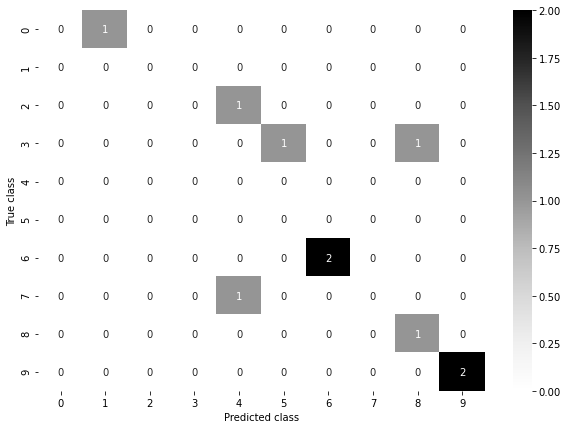

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## predicciones sobre test data mismo que muse 
predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greys',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)



In [23]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'ES-mBERT'            # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,           # training dataset
    eval_dataset = val_data,             # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train()


wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,No log,3.459473,0.024000,0.002300,0.001217,0.024000,2.151500,58.098000
2,3.445100,3.447560,0.024000,0.002313,0.001220,0.024000,2.155300,57.996000
3,3.437500,3.428427,0.032000,0.017734,0.145365,0.032000,2.077000,60.183000
4,3.437500,3.402795,0.064000,0.041474,0.042147,0.064000,2.075500,60.226000
5,3.395900,3.372270,0.080000,0.052381,0.038947,0.080000,2.073800,60.275000
6,3.362200,3.323838,0.144000,0.049334,0.050087,0.144000,2.182500,57.273000
7,3.362200,3.261272,0.144000,0.036766,0.021073,0.144000,2.078200,60.149000
8,3.289800,3.192991,0.144000,0.036252,0.020736,0.144000,2.171800,57.557000
9,3.184000,3.115340,0.144000,0.036252,0.020736,0.144000,2.089800,59.815000
10,3.077100,3.052046,0.152000,0.050743,0.069246,0.152000,2.168800,57.636000


TrainOutput(global_step=210, training_loss=2.3574287482670377, metrics={'train_runtime': 924.2596, 'train_samples_per_second': 0.227, 'total_flos': 1344746415600000.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 67058, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 4397760, 'train_mem_gpu_alloc_delta': 2850559488, 'train_mem_cpu_peaked_delta': 734451804, 'train_mem_gpu_peaked_delta': 2538697728})

In [25]:
model_path = "Chekmv_multi_chatbot"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chekmv_multi_chatbot/tokenizer_config.json',
 'Chekmv_multi_chatbot/special_tokens_map.json',
 'Chekmv_multi_chatbot/vocab.txt',
 'Chekmv_multi_chatbot/added_tokens.json')

In [24]:
trainer.evaluate()

wandb: WARNING Step must only increase in log calls.  Step 210 < 211; dropping {'eval/loss': 1.7903883457183838, 'eval/accuracy': 0.592, 'eval/f1': 0.5489436612922681, 'eval/precision': 0.5461043401043401, 'eval/recall': 0.592, 'eval/runtime': 2.0817, 'eval/samples_per_second': 60.047, 'train/epoch': 30.0}.


{'eval_loss': 1.7903883457183838,
 'eval_accuracy': 0.592,
 'eval_f1': 0.5489436612922681,
 'eval_precision': 0.5461043401043401,
 'eval_recall': 0.592,
 'eval_runtime': 2.0817,
 'eval_samples_per_second': 60.047,
 'epoch': 30.0,
 'eval_mem_cpu_alloc_delta': 94544,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 773684,
 'eval_mem_gpu_peaked_delta': 131883008}

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.00      0.00      0.00         1
           2       0.50      0.50      0.50         2
           3       0.33      0.50      0.40         2
           4       0.67      1.00      0.80        12
           5       0.60      0.75      0.67        12
           6       0.33      0.50      0.40         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.33      1.00      0.50         2
          10       0.00      0.00      0.00         1
          11       0.33      0.20      0.25         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.25      0.33      0.29         3
          16       1.00      1.00      1.00         1
          17       0.00    

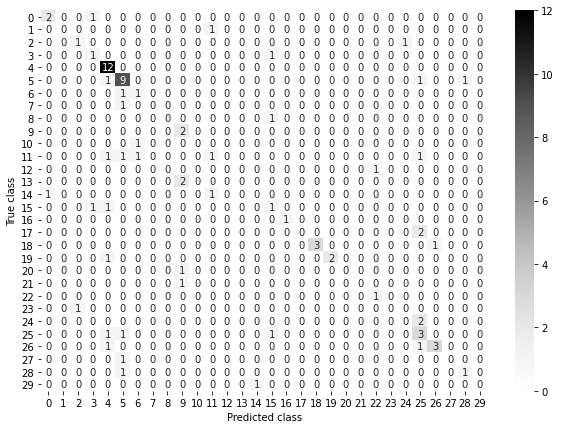

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## predicciones sobre test data en español
predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greys',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)



              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           2       0.00      0.00      0.00         0
           4       0.67      0.67      0.67         3
           5       1.00      0.14      0.25         7
           7       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          18       1.00      0.80      0.89         5
          21       0.00      0.00      0.00         3
          25       0.25      0.67      0.36         3
          26       0.75      1.00      0.86         6

    accuracy                           0.53        30
   macro avg       0.47      0.36      0.35        30
weighted avg       0.74      0.53      0.53        30

{'eval_loss': 1.9963164329528809, 'eval_accuracy': 0.5333333333333333, 'eval_f1': 0.5309403559403559, 'eval_precision': 0.7416666666666667, 'eval_recall': 0.5333333333333333, 'eval_runtime': 0.5588, 'eval_samples_per_second': 53.69, 'test_me

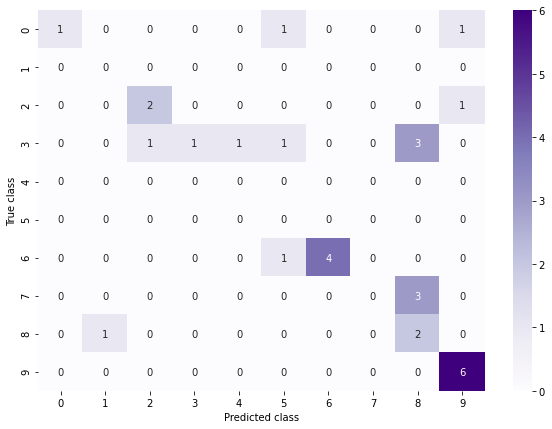

In [29]:
## Test sobre dato en ingles

#Test Dato español  

path3 = "chatbot_testEN.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.Query.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.category_cod.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_ES)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)



In [ ]:
## Few Shot

In [27]:
model_dir="./"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir = model_dir +  'prueba/results',          # output directory
    overwrite_output_dir = True,
    evaluation_strategy='epoch',
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir = model_dir +  'prueba/logs',            # directory for storing logs
    logging_steps=10,
    load_best_model_at_end = True,
    #report_to = 'wandb',           # enable logging to W&B
    run_name = 'ES + EN -mBERT'   # name of the W&B run
)

trainer = Trainer(
    model = model,                         # the instantiated 🤗 Transformers model to be trained
    args = training_args,                  # training arguments, defined above
    train_dataset = train_data,           # training dataset
    eval_dataset = val_data,             # evaluation dataset
    compute_metrics=compute_metrics            
)

trainer.train()

wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,No log,3.431278,0.056000,0.013744,0.011055,0.056000,2.154700,58.014000
2,3.427200,3.421836,0.056000,0.013695,0.011027,0.056000,2.147400,58.210000
3,3.411400,3.405759,0.056000,0.013463,0.010897,0.056000,2.166100,57.708000
4,3.411400,3.380547,0.064000,0.015143,0.009600,0.064000,2.064100,60.558000
5,3.367900,3.339538,0.104000,0.042446,0.027867,0.104000,2.082200,60.033000
6,3.334000,3.278684,0.152000,0.051695,0.093421,0.152000,2.158600,57.909000
7,3.334000,3.211559,0.144000,0.036507,0.020903,0.144000,2.153800,58.037000
8,3.244500,3.135100,0.152000,0.051166,0.093073,0.152000,2.158900,57.899000
9,3.096100,3.063343,0.144000,0.047737,0.044571,0.144000,2.058400,60.726000
10,3.000200,3.012494,0.176000,0.082991,0.057034,0.176000,2.163700,57.772000


TrainOutput(global_step=210, training_loss=2.3012320382254465, metrics={'train_runtime': 1352.151, 'train_samples_per_second': 0.155, 'total_flos': 1408781959200000.0, 'epoch': 30.0, 'init_mem_cpu_alloc_delta': 67393, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 4395485, 'train_mem_gpu_alloc_delta': 2850591232, 'train_mem_cpu_peaked_delta': 734441873, 'train_mem_gpu_peaked_delta': 2538665984})

In [29]:
trainer.evaluate()

wandb: WARNING Step must only increase in log calls.  Step 210 < 211; dropping {'eval/loss': 1.9216972589492798, 'eval/accuracy': 0.528, 'eval/f1': 0.49813277591291766, 'eval/precision': 0.5117875776397516, 'eval/recall': 0.528, 'eval/runtime': 2.0777, 'eval/samples_per_second': 60.164, 'train/epoch': 30.0}.


{'eval_loss': 1.9216972589492798,
 'eval_accuracy': 0.528,
 'eval_f1': 0.49813277591291766,
 'eval_precision': 0.5117875776397516,
 'eval_recall': 0.528,
 'eval_runtime': 2.0777,
 'eval_samples_per_second': 60.164,
 'epoch': 30.0,
 'eval_mem_cpu_alloc_delta': 98355,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 775759,
 'eval_mem_gpu_peaked_delta': 131883008}

In [28]:
model_path = "Chekmv_multi_chatbot_fewshot"
trainer.save_model(model_path)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('Chekmv_multi_chatbot_fewshot/tokenizer_config.json',
 'Chekmv_multi_chatbot_fewshot/special_tokens_map.json',
 'Chekmv_multi_chatbot_fewshot/vocab.txt',
 'Chekmv_multi_chatbot_fewshot/added_tokens.json')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         2
           5       1.00      0.20      0.33         5
          11       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         3
          21       0.00      0.00      0.00         3
          25       0.25      1.00      0.40         1
          26       0.83      1.00      0.91         5

    accuracy                           0.60        20
   macro avg       0.45      0.47      0.40        20
weighted avg       0.72      0.60      0.58        20

{'eval_loss': 1.8489347696304321, 'eval_accuracy': 0.6, 'eval_f1': 0.5806060606060606, 'eval_precision': 0.7208333333333334, 'eval_recall': 0.6, 'eval_runtime': 0.4386, 'eval_samples_per_second': 45.596, 'test_mem_cpu_alloc_delta': 68221, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delt

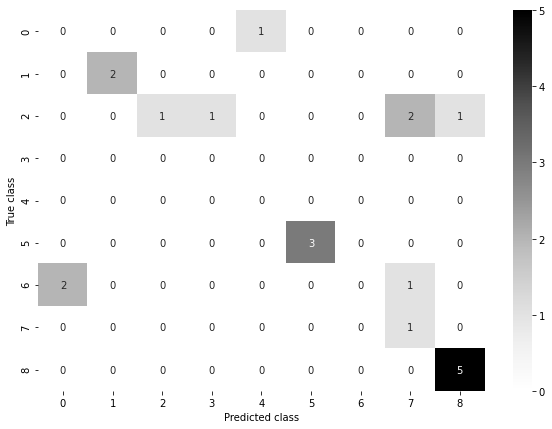

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

## predicciones sobre test data en ingles 
predictions,labels, metrics = trainer.predict(test_data)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Greys',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.00      0.00      0.00         1
           2       1.00      0.50      0.67         2
           3       0.33      0.50      0.40         2
           4       0.63      1.00      0.77        12
           5       0.56      0.83      0.67        12
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       0.40      1.00      0.57         2
          10       0.00      0.00      0.00         1
          11       0.18      0.40      0.25         5
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         2
          15       0.20      0.33      0.25         3
          16       0.00      0.00      0.00         1
          17       1.00    

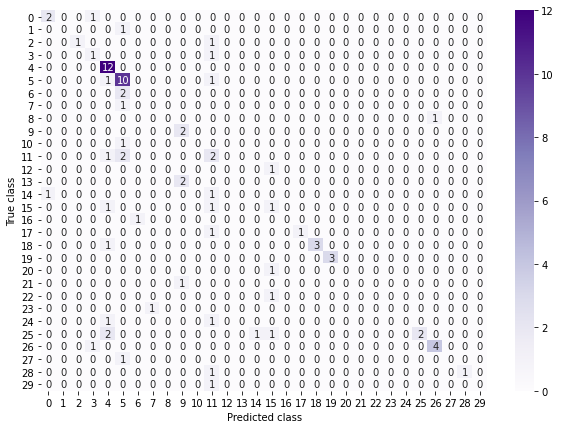

In [31]:
## Test sobre dato en ingles

#Test Dato español  

path3 = "chatbot_testES.csv"
df_test = pd.read_csv(path3)
df_test = df_test

test_encodings = tokenizer(df_test.Query.values.tolist(), #truncation=True, padding=True,
      add_special_tokens=True,
      truncation=True,
      max_length=MAX_LENGTH,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt')

test_labels = df_test.category_cod.values
test_data_ES = GPReviewDataset(test_encodings, torch.from_numpy(test_labels))

## predicciones sobre valid data en ESPAÑOL
predictions,labels, metrics = trainer.predict(test_data_ES)  

# MATRIZ DE CONFUSION
matrix = confusion_matrix(labels, predictions.argmax(axis=1))

plt.figure(figsize = (10,7))
## Confusion matrix with counts
sns.heatmap(matrix, annot=True,cmap='Purples',fmt='g')

#sns.heatmap(matrix/np.sum(matrix), annot=True, 
#          fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

clas_report = classification_report(labels, predictions.argmax(axis=1))

print(clas_report)
print(metrics)

